## underfit-overfit

In [1]:
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon

num_train = 100
num_test = 100
true_w = [1.2, -3.4, 5.6]
true_b = 5.0

In [2]:
x = nd.random.normal(shape=(num_train + num_test, 1))
X = nd.concat(x, nd.power(x, 2), nd.power(x, 3))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_w[2] * X[:, 2] + true_b
y += .1 * nd.random.normal(shape=y.shape)

('x:', x[:5], 'X:', X[:5], 'y:', y[:5])

('x:', 
 [[ 1.16307867]
  [ 0.48380461]
  [ 0.29956347]
  [ 0.15302546]
  [-1.16881478]]
 <NDArray 5x1 @cpu(0)>, 'X:', 
 [[ 1.16307867  1.35275197  1.57335699]
  [ 0.48380461  0.2340669   0.11324265]
  [ 0.29956347  0.08973827  0.02688231]
  [ 0.15302546  0.02341679  0.00358337]
  [-1.16881478  1.36612797 -1.59675062]]
 <NDArray 5x3 @cpu(0)>, 'y:', 
 [ 10.5346508    5.53009319   5.1570797    5.00668526 -10.06843472]
 <NDArray 5 @cpu(0)>)

In [3]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def train(X_train, X_test, y_train, y_test):
    # 线性回归模型
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    net.initialize()
    # 设一些默认参数
    learning_rate = 0.01
    epochs = 100
    batch_size = min(10, y_train.shape[0])
    dataset_train = gluon.data.ArrayDataset(X_train, y_train)
    data_iter_train = gluon.data.DataLoader(
        dataset_train, batch_size, shuffle=True)
    # 默认SGD和均方误差
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {
        'learning_rate': learning_rate})
    square_loss = gluon.loss.L2Loss()
    # 保存训练和测试损失
    train_loss = []
    test_loss = []
    for e in range(epochs):
        for data, label in data_iter_train:
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)
        train_loss.append(square_loss(
            net(X_train), y_train).mean().asscalar())
        test_loss.append(square_loss(
            net(X_test), y_test).mean().asscalar())
    # 打印结果
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train','test'])
    plt.show()
    return ('learned weight', net[0].weight.data(),
            'learned bias', net[0].bias.data())

fit

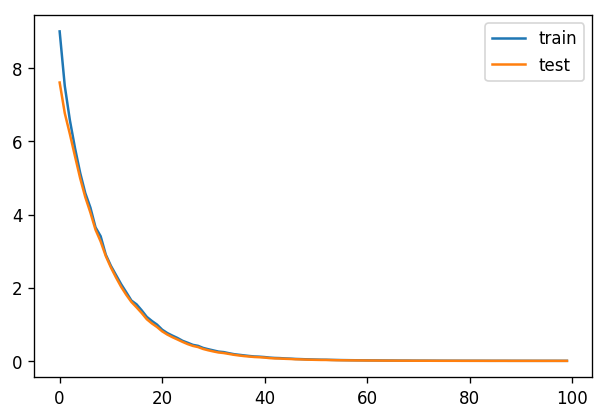

('learned weight', 
 [[ 1.17046332 -3.39069533  5.60172462]]
 <NDArray 1x3 @cpu(0)>, 'learned bias', 
 [ 4.98592758]
 <NDArray 1 @cpu(0)>)

In [4]:
train(X[:num_train, :], X[num_train:, :], y[:num_train], y[num_train:])

underfit

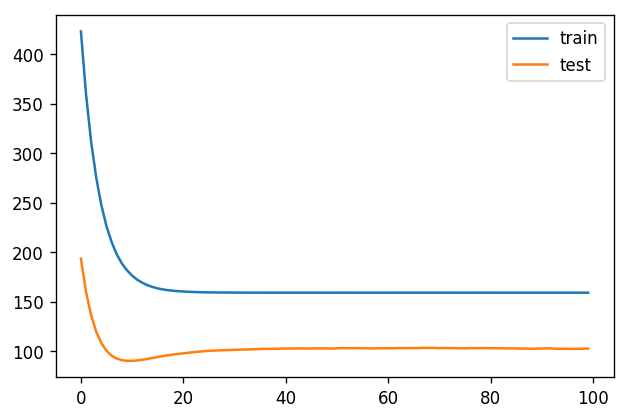

('learned weight', 
 [[ 22.65612221]]
 <NDArray 1x1 @cpu(0)>, 'learned bias', 
 [-0.64511251]
 <NDArray 1 @cpu(0)>)

In [5]:
train(x[:num_train, :], x[num_train:, :], y[:num_train], y[num_train:])

overfit

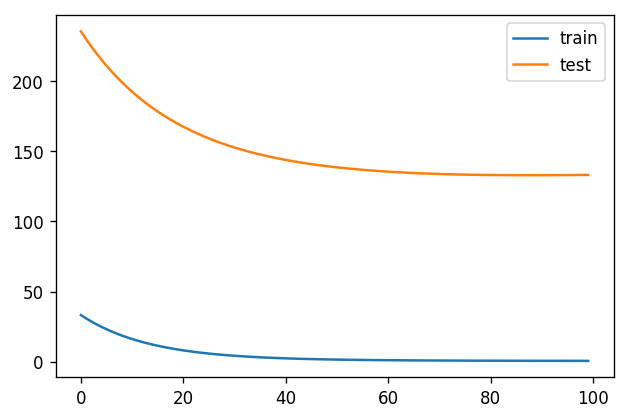

('learned weight', 
 [[ 2.05884552  1.92736697  2.0477407 ]]
 <NDArray 1x3 @cpu(0)>, 'learned bias', 
 [ 2.4821291]
 <NDArray 1 @cpu(0)>)

In [6]:
train(X[0:2, :], X[num_train:, :], y[0:2], y[num_train:])

## reg-scratch

In [7]:
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon
import mxnet as mx

num_train = 20
num_test = 100
num_inputs = 200

true_w = nd.ones((num_inputs, 1)) * 0.01
true_b = 0.05


X = nd.random.normal(shape=(num_train + num_test, num_inputs))
y = nd.dot(X, true_w) + true_b
y += .01 * nd.random.normal(shape=y.shape)

X_train, X_test = X[:num_train, :], X[num_train:, :]
y_train, y_test = y[:num_train], y[num_train:]

In [8]:
import random
batch_size = 1
def data_iter(num_examples):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for i in range(0, num_examples, batch_size):
        j = nd.array(idx[i:min(i+batch_size,num_examples)])
        yield X.take(j), y.take(j)

In [13]:
def init_params():
    w = nd.random_normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    params = [w, b]
    for param in params:
        param.attach_grad()
    return params

In [10]:
def L2_penalty(w, b):
    return ((w**2).sum() + b**2) / 2

In [11]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt
import numpy as np

def net(X, w, b):
    return nd.dot(X, w) + b

def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape)) ** 2 / 2

def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size

def test(net, params, X, y):
    return square_loss(net(X, *params), y).mean().asscalar()
    #return np.mean(square_loss(net(X, *params), y).asnumpy())

def train(lambd):
    epochs = 10
    learning_rate = 0.005
    w, b = params = init_params()
    train_loss = []
    test_loss = []
    for e in range(epochs):
        for data, label in data_iter(num_train):
            with autograd.record():
                output = net(data, *params)
                loss = square_loss(
                    output, label) + lambd * L2_penalty(*params)
            loss.backward()
            sgd(params, learning_rate, batch_size)
        train_loss.append(test(net, params, X_train, y_train))
        test_loss.append(test(net, params, X_test, y_test))
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train', 'test'])
    plt.show()
    return 'learned w[:10]:', w[:10].T, 'learned b:', b

without regularization

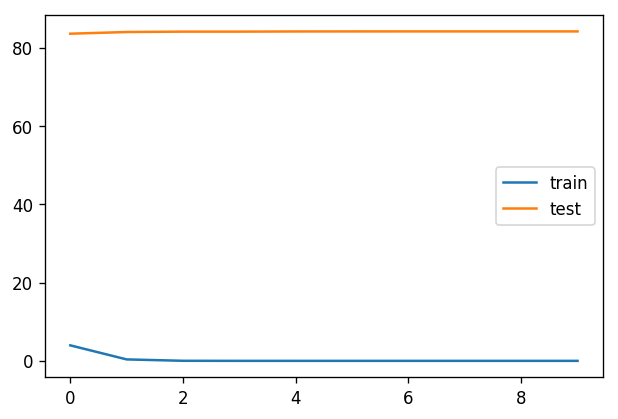

('learned w[:10]:', 
 [[ 0.02654516 -0.92490417 -2.57755518 -0.2259074  -0.20298758 -0.07110765
    0.06192364 -0.0877983  -0.43305358 -1.32045364]]
 <NDArray 1x10 @cpu(0)>, 'learned b:', 
 [-0.09419394]
 <NDArray 1 @cpu(0)>)

In [12]:
train(0)

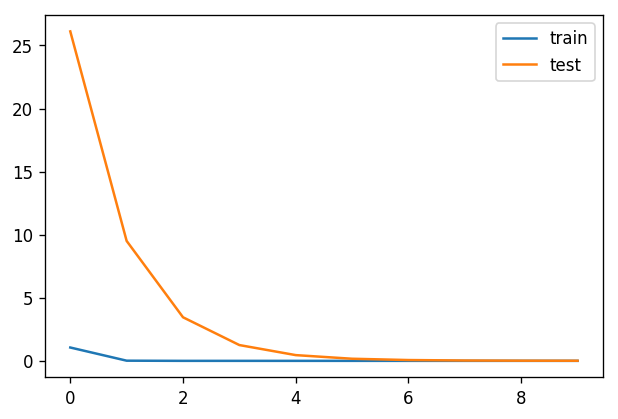

('learned w[:10]:', 
 [[-0.00348316 -0.00242414  0.00840932  0.01700662 -0.00652676  0.00267539
    0.0035417   0.00145079 -0.00829152 -0.00286944]]
 <NDArray 1x10 @cpu(0)>, 'learned b:', 
 [ 0.00491545]
 <NDArray 1 @cpu(0)>)

In [14]:
train(5)

## reg-gluon

In [15]:
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon
import mxnet as mx

num_train = 20
num_test = 100
num_inputs = 200

true_w = nd.ones((num_inputs, 1)) * 0.01
true_b = 0.05

X = nd.random.normal(shape=(num_train + num_test, num_inputs))
y = nd.dot(X, true_w) + true_b
y += .01 * nd.random.normal(shape=y.shape)

X_train, X_test = X[:num_train, :], X[num_train:, :]
y_train, y_test = y[:num_train], y[num_train:]

In [16]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt
import numpy as np

batch_size = 1
dataset_train = gluon.data.ArrayDataset(X_train, y_train)
data_iter_train = gluon.data.DataLoader(dataset_train, batch_size, shuffle=True)

square_loss = gluon.loss.L2Loss()

def test(net, X, y):
    return square_loss(net(X), y).mean().asscalar()

def train(weight_decay):
    epochs = 10
    learning_rate = 0.005
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    net.collect_params().initialize(mx.init.Normal(sigma=1))

    # 注意到这里 'wd'
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {
        'learning_rate': learning_rate, 'wd': weight_decay})

    train_loss = []
    test_loss = []
    for e in range(epochs):
        for data, label in data_iter_train:
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)
        train_loss.append(test(net, X_train, y_train))
        test_loss.append(test(net, X_test, y_test))
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train','test'])
    plt.show()

    return ('learned w[:10]:', net[0].weight.data()[:,:10],
            'learned b:', net[0].bias.data())

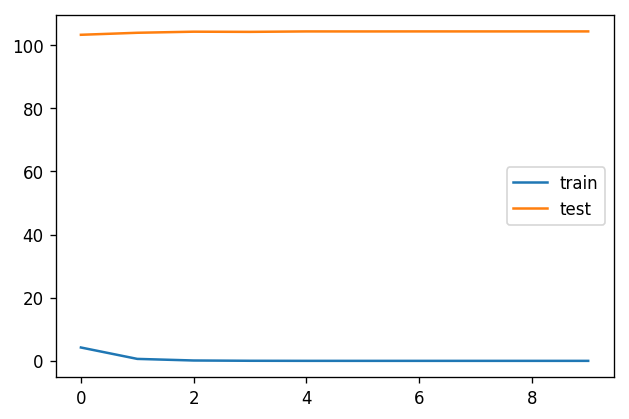

('learned w[:10]:', 
 [[-1.98230195  0.1076458  -0.95796049  0.22393775 -0.31482884  0.16134623
    0.17466423 -0.4261528  -0.0182331  -0.89445305]]
 <NDArray 1x10 @cpu(0)>, 'learned b:', 
 [ 0.01042501]
 <NDArray 1 @cpu(0)>)

In [17]:
train(0)

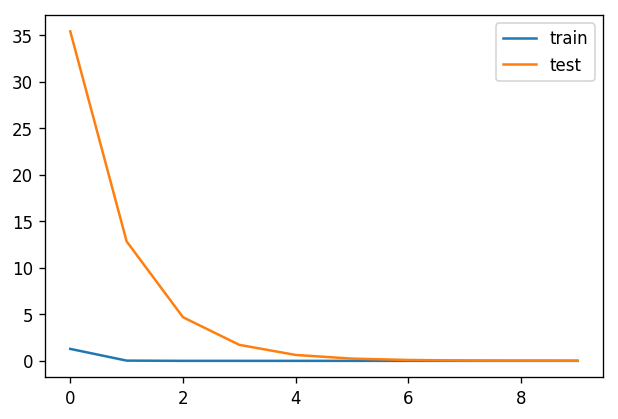

('learned w[:10]:', 
 [[  9.78055038e-03  -3.39205423e-03  -8.95440020e-03  -5.20462170e-04
    -1.19337440e-02  -1.85779436e-03   1.26178598e-03   2.47172429e-05
     2.06974328e-05  -9.17418953e-03]]
 <NDArray 1x10 @cpu(0)>, 'learned b:', 
 [ 0.00574432]
 <NDArray 1 @cpu(0)>)

In [18]:
train(5)